 # Pilot Distraction Prediction

![alt text](https://www.telegraph.co.uk/content/dam/Travel/2017/june/pilot-plane.jpg)

First Lets's bring data from kaggle.com.
in Kaggle.com
Click on My Account => Create new API. You will recieve Kaggle Json file from kaggle, Save the same in one folder on your desktop and then run below code to bring data on your google colab. 

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 
!kaggle competitions download -c reducing-commercial-aviation-fatalities

 78% 32.0M/41.2M [00:00<00:00, 40.7MB/s]
100% 41.2M/41.2M [00:00<00:00, 76.4MB/s]
100% 435M/435M [00:05<00:00, 97.9MB/s]

 99% 1.65G/1.67G [00:21<00:00, 97.3MB/s]
100% 1.67G/1.67G [00:21<00:00, 83.2MB/s]


### **Import Libraries**

In [0]:
import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss

warnings.simplefilter(action='ignore')
sns.set_style('whitegrid')

## 1 - Loading the Data

In [0]:
dtypes = {"crew": "int8",
          "experiment": "category",
          "time": "float32",
          "seat": "int8",
          "eeg_fp1": "float32",
          "eeg_f7": "float32",
          "eeg_f8": "float32",
          "eeg_t4": "float32",
          "eeg_t6": "float32",
          "eeg_t5": "float32",
          "eeg_t3": "float32",
          "eeg_fp2": "float32",
          "eeg_o1": "float32",
          "eeg_p3": "float32",
          "eeg_pz": "float32",
          "eeg_f3": "float32",
          "eeg_fz": "float32",
          "eeg_f4": "float32",
          "eeg_c4": "float32",
          "eeg_p4": "float32",
          "eeg_poz": "float32",
          "eeg_c3": "float32",
          "eeg_cz": "float32",
          "eeg_o2": "float32",
          "ecg": "float32",
          "r": "float32",
          "gsr": "float32",
          "event": "category",
         }

In [0]:
# Unzip the train folder using below command
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [0]:
# Dataframe creation using pandas libraries
train_df = pd.read_csv("/content/train.csv", dtype=dtypes)
#test_df = pd.read_csv("../input/test.csv", dtype=dtypes)

In [0]:
#Data set information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
crew          int8
experiment    category
time          float32
seat          int8
eeg_fp1       float32
eeg_f7        float32
eeg_f8        float32
eeg_t4        float32
eeg_t6        float32
eeg_t5        float32
eeg_t3        float32
eeg_fp2       float32
eeg_o1        float32
eeg_p3        float32
eeg_pz        float32
eeg_f3        float32
eeg_fz        float32
eeg_f4        float32
eeg_c4        float32
eeg_p4        float32
eeg_poz       float32
eeg_c3        float32
eeg_cz        float32
eeg_o2        float32
ecg           float32
r             float32
gsr           float32
event         category
dtypes: category(2), float32(24), int8(2)
memory usage: 464.2 MB


No missing values.

In [0]:
# Printing top 5 observations of each variable
train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,-6.695870,29.232100,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,-6.474720,26.641399,24.138800,5.46991,20.510599,2.83354,7.10177,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,-0.088707,28.119900,26.891300,8.57886,23.162901,4.51993,12.70550,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,-0.256516,30.653601,24.247000,8.64310,19.961901,7.27575,11.45980,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,-1.953470,31.722601,25.155500,12.50030,18.746901,7.30976,8.00805,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [0]:
#test_df.head()

## 2 - EDA

### Target & Experiment

These are specific technical terms which is used in Aviation industry

Pilot Distraction has Three Cognitive states:-

- **Channelized Attention (CA)** :-The state of being focused on one task to the exclusion of all others. This can be understood as subject is playing aviation video game.
- **Diverted Attention (DA)** :-This is the state of having one’s(Pilot) attention diverted by actions or thought processes associated with a decision. This is induced by having the subjects perform a display monitoring task. Periodically, a math problem showed up which had to be solved before returning to the monitoring task.
- **Startle/Surprise (SS)** is induced by having the subjects watch movie clips with jump scares.

Samples are labelled the following way : 
- A = baseline
- B = SS
- C = CA
- D = DA

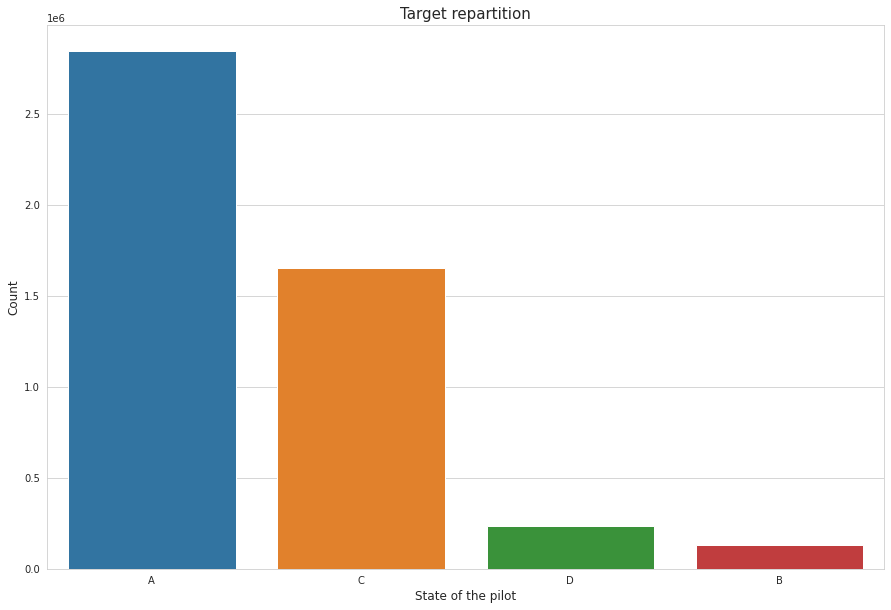

In [0]:
# Lets check Distribution of assigned Labels
plt.figure(figsize=(15,10))
sns.countplot(train_df['event'])
plt.xlabel("State of the pilot", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Target repartition", fontsize=15)
plt.show()

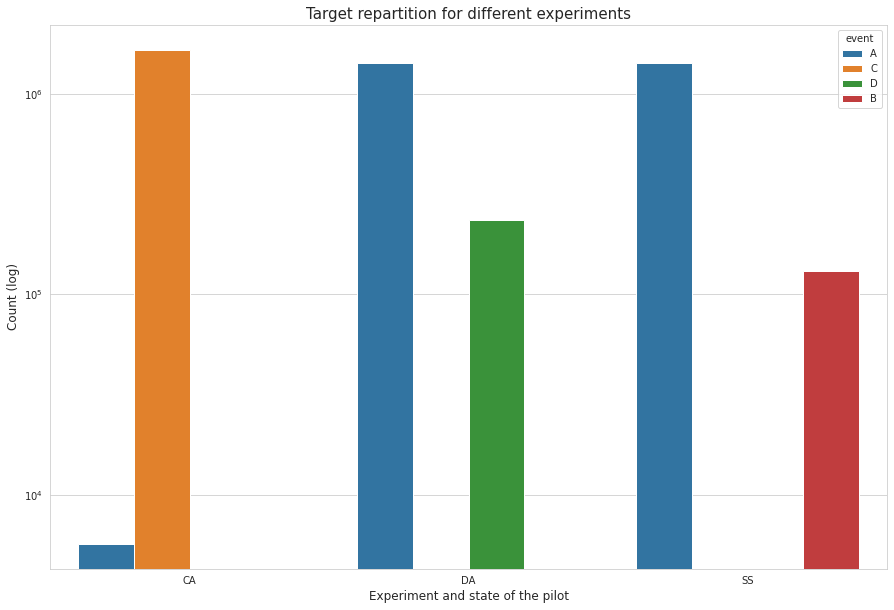

In [0]:
# Checking distribution with "Experiment"
plt.figure(figsize=(15,10))
sns.countplot('experiment', hue='event', data=train_df)
plt.xlabel("Experiment and state of the pilot", fontsize=12)
plt.ylabel("Count (log)", fontsize=12)
plt.yscale('log')
plt.title("Target repartition for different experiments", fontsize=15)
plt.show()

### Seat
Assignment of sitting for the Pilot
Which seat the pilot is sitting in.
- 0 : left seat
- 1 : right seat

This might have not needed in prediction.


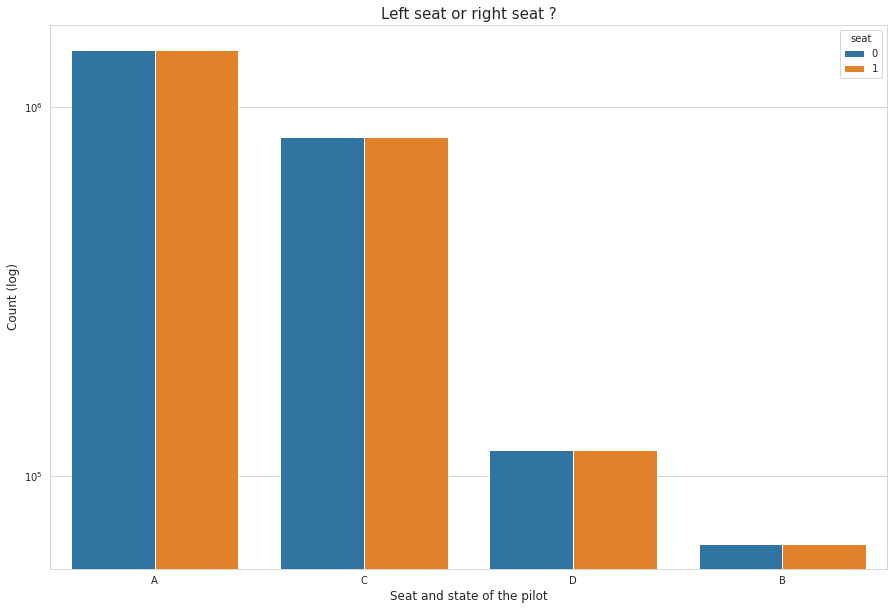

In [0]:
# Checking distribution with "Event" and "Seat"
plt.figure(figsize=(15,10))
sns.countplot('event', hue='seat', data=train_df)
plt.xlabel("Seat and state of the pilot", fontsize=12)
plt.ylabel("Count (log)", fontsize=12)
plt.yscale('log')
plt.title("Left seat or right seat ?", fontsize=15)
plt.show()

### Time of the experiment

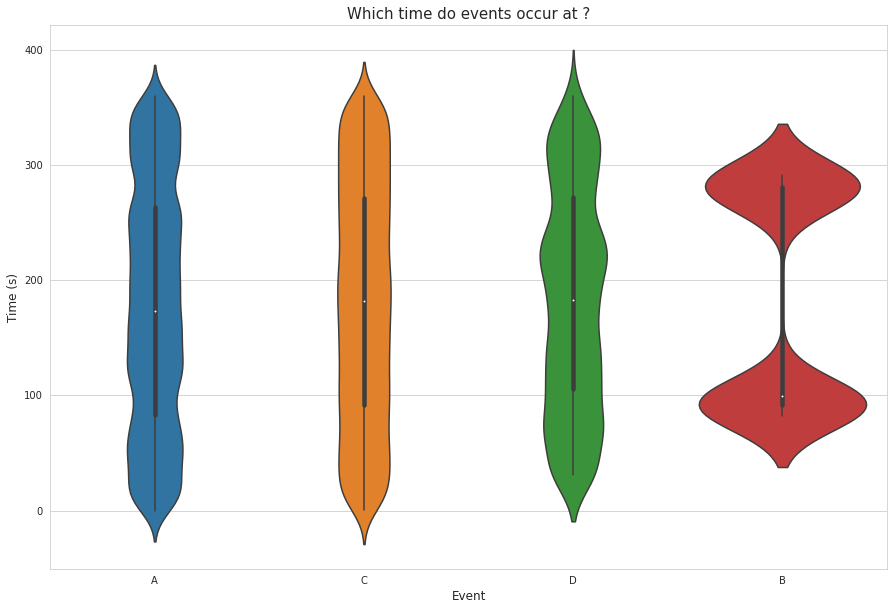

In [0]:
plt.figure(figsize=(15,10))
sns.violinplot(x='event', y='time', data=train_df.sample(50000))
plt.ylabel("Time (s)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Which time do events occur at ?", fontsize=15)
plt.show()

### Electroencephalogram recordings

In [0]:
eeg_features = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]

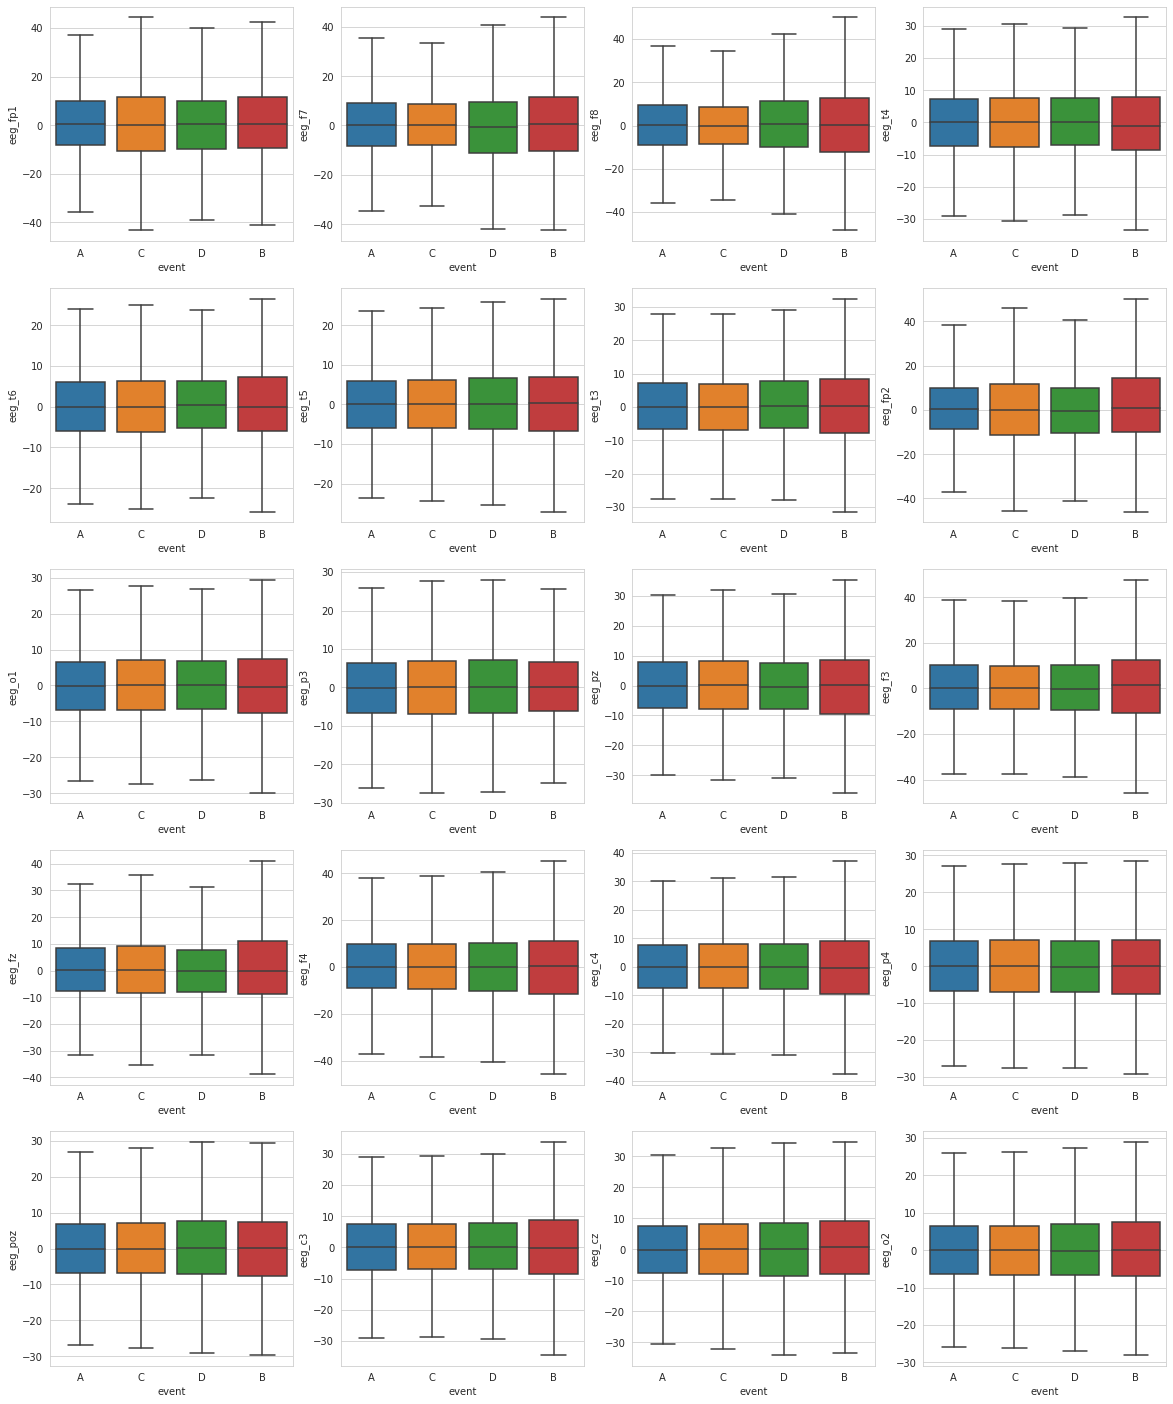

In [0]:
plt.figure(figsize=(20,25))
i = 0

for egg in eeg_features:
    i += 1
    plt.subplot(5, 4, i)
    sns.boxplot(x='event', y=egg, data=train_df.sample(50000), showfliers=False)

plt.show()

We Also check if features have the same distribution on the train set

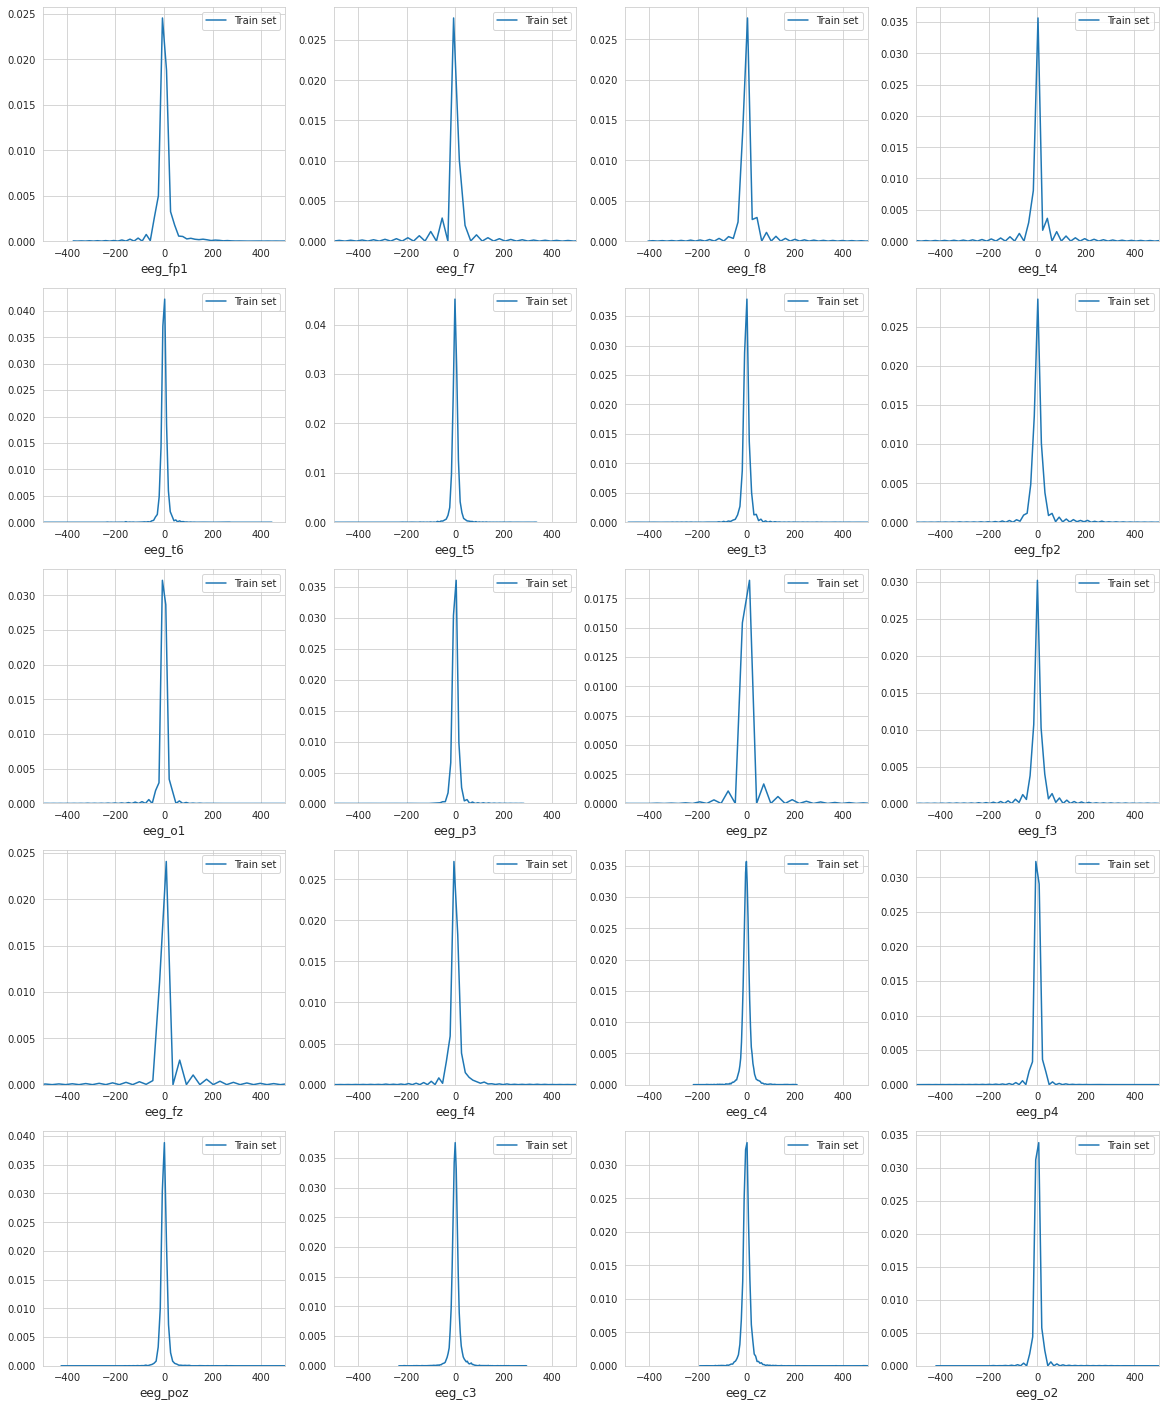

In [0]:
# Eeg features distribution and how they spreaded near the "mean"
plt.figure(figsize=(20,25))
plt.title('Eeg features distributions')
i = 0

for eeg in eeg_features:
    i += 1
    plt.subplot(5, 4, i)
    #sns.distplot(test_df.sample(10000)[eeg], label='Test set', hist=False)
    sns.distplot(train_df.sample(10000)[eeg], label='Train set', hist=False)
    plt.xlim((-500, 500))
    plt.legend()
    plt.xlabel(eeg, fontsize=12)

plt.show()

Reparitions seem consistent :  Gaussians with a sinusoïdal noise centered at 0.

### Electrocardiogram
- 3-point Electrocardiogram signal. The sensor had a resolution/bit of .012215 µV and a range of -100mV to +100mV. The data are provided in microvolts.

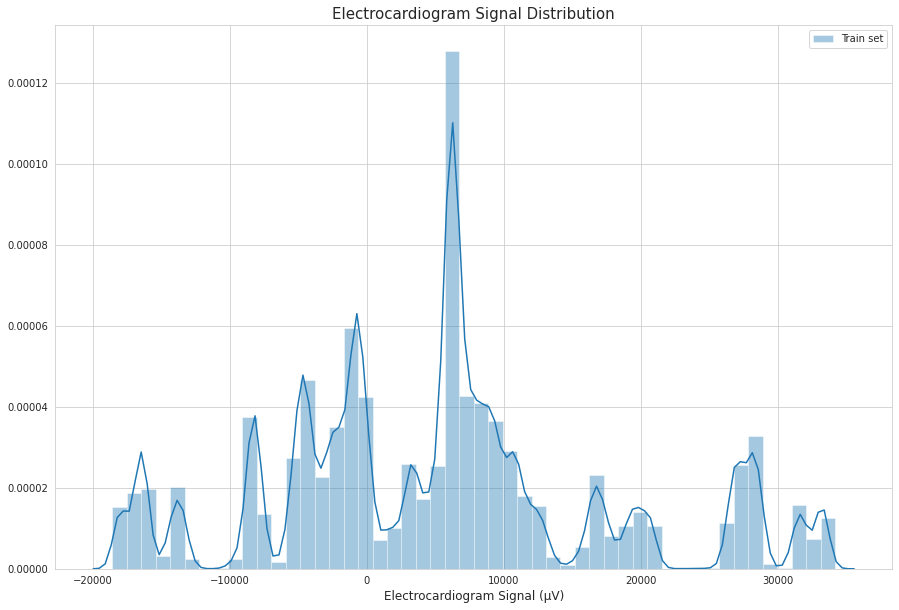

In [0]:
# We will check distribution of Electrocardigram signal for the train dataset -100mV to +100mV
plt.figure(figsize=(15,10))
#sns.distplot(test_df['ecg'], label='Test set')
sns.distplot(train_df['ecg'], label='Train set')
plt.legend()
plt.xlabel("Electrocardiogram Signal (µV)", fontsize=12)
plt.title("Electrocardiogram Signal Distribution", fontsize=15)
plt.show()

Except foir the >20000-ish samples, train repartitions are similar.

### Respiration 
- A measure of the rise and fall of the chest. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.

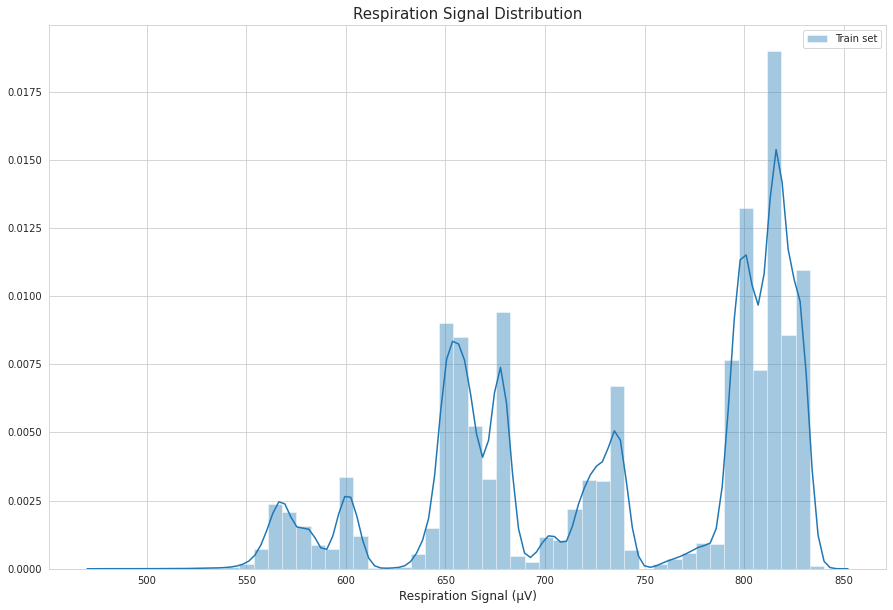

In [0]:
# Here we shall be checking distribution of Respiration signal distribution between the range -2.0V to +2.0V
plt.figure(figsize=(15,10))
#sns.distplot(test_df['r'], label='Test set')
sns.distplot(train_df['r'], label='Train set')
plt.legend()
plt.xlabel("Respiration Signal (µV)", fontsize=12)
plt.title("Respiration Signal Distribution", fontsize=15)
plt.show()

### Galvanic Skin Response
 - A measure of electrodermal activity. The sensor had a resolution/bit of .2384186 µV and a range of -2.0V to +2.0V. The data are provided in microvolts.
 > "The galvanic skin response (GSR, which falls under the umbrella term of electrodermal activity, or EDA) refers to changes in sweat gland activity that are reflective of the intensity of our emotional state, otherwise known as emotional arousal."

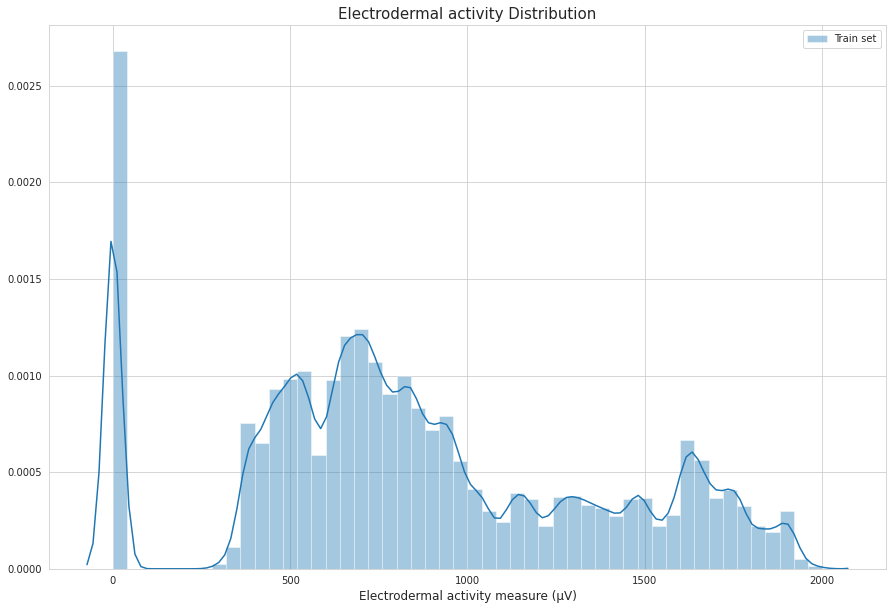

In [0]:
plt.figure(figsize=(15,10))
#sns.distplot(test_df['gsr'], label='Test set')
sns.distplot(train_df['gsr'], label='Train set')
plt.legend()
plt.xlabel("Electrodermal activity measure (µV)", fontsize=12)
plt.title("Electrodermal activity Distribution", fontsize=15)
plt.show()

## 3 - Gradient Boosting

### Normalizing 

Because of earlier remarks, we normalize our features. 

I do believe the following features depend a lot of the person, therefore I apply a Min/Max Scaler for each pilot.

In [0]:
features_n = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2", "ecg", "r", "gsr"]

In [0]:
train_df['pilot'] = 100 * train_df['seat'] + train_df['crew']
#test_df['pilot'] = 100 * test_df['seat'] + test_df['crew']

print("Number of pilots : ", len(train_df['pilot'].unique()))

Number of pilots :  18


In [0]:
def normalize_by_pilots(df):
    pilots = df["pilot"].unique()
    for pilot in tqdm(pilots):
        ids = df[df["pilot"] == pilot].index
        scaler = MinMaxScaler()
        df.loc[ids, features_n] = scaler.fit_transform(df.loc[ids, features_n])
        
    return df

In [0]:
train_df = normalize_by_pilots(train_df)
#test_df = normalize_by_pilots(test_df)

### Train / Test split

In [0]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=420)
print(f"Training on {train_df.shape[0]} samples.")

Training on 3893936 samples.


### Model
Note that I did not bother tweaking the parameters yet.

In [0]:
features = ["crew", "seat"] + features_n
      
def run_lgb(df_train, df_test):
    # Classes as integers
    dic = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    try:
        df_train["event"] = df_train["event"].apply(lambda x: dic[x])
       #df_test["event"] = df_test["event"].apply(lambda x: dic[x])
    except: 
        pass
    
    params = {"objective" : "multiclass",
              "num_class": 4,
              "metric" : "multi_error",
              "num_leaves" : 30,
              "min_child_weight" : 50,
              "learning_rate" : 0.1,
              "bagging_fraction" : 0.7,
              "feature_fraction" : 0.7,
              "bagging_seed" : 420,
              "verbosity" : -1
             }
    
    lg_train = lgb.Dataset(df_train[features], label=(df_train["event"]))
    #lg_test = lgb.Dataset(df_test[features], label=(df_test["event"]))
    model = lgb.train(params, lg_train, 1000, valid_sets=[lg_test], early_stopping_rounds=50, verbose_eval=100)
    
    return model

In [0]:
model = run_lgb(train_df, val_df)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_error: 0.082822
[200]	valid_0's multi_error: 0.0680144
[300]	valid_0's multi_error: 0.0594349
[400]	valid_0's multi_error: 0.0538796
[500]	valid_0's multi_error: 0.0497203
[600]	valid_0's multi_error: 0.0463869
[700]	valid_0's multi_error: 0.0437973
[800]	valid_0's multi_error: 0.0415733
[900]	valid_0's multi_error: 0.0397613
[1000]	valid_0's multi_error: 0.0381639
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_error: 0.0381639


### Feature importance

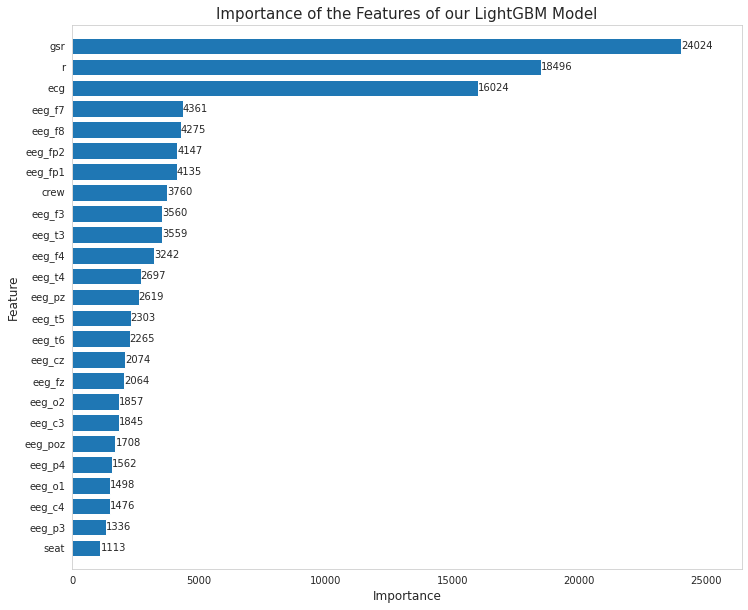

In [0]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of our LightGBM Model", fontsize=15)
plt.show()

### Confusion Matrix

In [0]:
pred_val = model.predict(val_df[features], num_iteration=model.best_iteration)
#pred_train = model.predict(train_df[features], num_iteration=model.best_iteration)

In [0]:
print("Log loss on validation data :", round(log_loss(np.array(val_df["event"].values), pred_val), 3))

Log loss on validation data : 0.108


In [0]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f' if normalize else 'd'

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

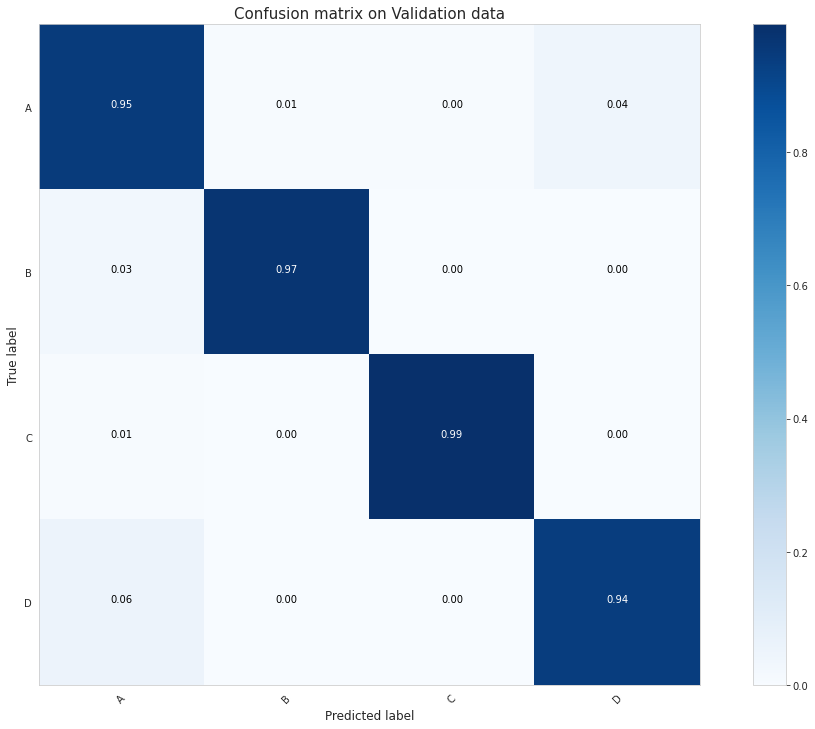

In [0]:
conf_mat_val = confusion_matrix(np.argmax(pred_val, axis=1), val_df["event"].values)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)